# Feature weights for larger `$OBS` and `$SUG` categories (random forest model) by evaluation after introducing token-based features

In [1]:
import numpy as np
import pandas as pd
import sys, warnings
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=Warning)

Basic parameters

In [2]:
N_TREES = 20
N_FOLDS = 5

MIN_OBS_THRESHOLD = 50
MIN_SUG_THRESHOLD = 50

In [3]:
df_full_obs = pd.read_csv('res/features_by_eval_with_normalized_token_scores.tsv', sep='\t')
df_full_sug = pd.read_csv('res/labels_by_eval_with_normalized_token_scores.tsv', sep='\t')

Out of the 40-odd `$OBS` and `$SUG` categories, first filter out minor categories without many notes.

In [4]:
obs_cols_to_keep = [
    x[0]
    for x in df_full_obs.astype('bool').sum().iteritems()
    if x[1] >= MIN_OBS_THRESHOLD
]

sug_cols_to_keep = [
    x[0]
    for x in df_full_sug.astype('bool').sum().iteritems()
    if x[1] >= MIN_SUG_THRESHOLD
]

df_smaller_obs = df_full_obs[obs_cols_to_keep]
df_smaller_sug = df_full_sug[sug_cols_to_keep]

In [5]:
rf = RandomForestClassifier(n_estimators=N_TREES, n_jobs=-1)

For each `$SUG` category, I use k-fold cross validation and fit my `$OBS` matrix, averaging the feature importances of each `$OBS` categories across each fold.

In [13]:
sug_cat_to_feature_importances = {}
sug_cat_to_predictability = {}

print('Fitting models for each label:\n[' + '  ' * len(df_smaller_sug.columns) + ']', end='', flush=True)

for i, sug_cat in enumerate(df_smaller_sug):
    output = cross_validate(
        rf,
        df_smaller_obs,
        df_smaller_sug[sug_cat],
        cv=N_FOLDS,
        return_estimator=True
    )
    obs_cat_to_mean_importance = defaultdict(list)
    sug_cat_to_predictability[sug_cat] = output['test_score'].mean()
    
    for idx, estimator in enumerate(output['estimator']):
        feature_importances = pd.DataFrame(
            estimator.feature_importances_,
            index = df_smaller_obs.columns,
            columns=['importance']
        )
        for cat, imp in dict(feature_importances['importance']).items():
            obs_cat_to_mean_importance[cat].append(imp)
            
    for cat, imp_list in obs_cat_to_mean_importance.items():
        obs_cat_to_mean_importance[cat] = sum(imp_list) / len(imp_list)
    sug_cat_to_feature_importances[sug_cat] = obs_cat_to_mean_importance
    
    print('\r[' + '==' * i + '=>', end='', flush=True)
print('\r[' + '==' * len(df_smaller_sug.columns) + '] Done.', end='')

Fitting models for each label:
[========================] Done.

In [7]:
for_hm_sug_cats = sorted(list(sug_cat_to_feature_importances.keys()))
for_hm_obs_cats = sorted(list(sug_cat_to_feature_importances[list(sug_cat_to_feature_importances)[0]].keys()))

In [8]:
corr_matrix = pd.DataFrame([
[
        sug_cat_to_feature_importances[sug_cat][obs_cat] * len(for_hm_obs_cats)
        for sug_cat in for_hm_sug_cats
    ]
    for obs_cat in for_hm_obs_cats
])

In [9]:
corr_matrix.rename(index={idx: x for idx, x in enumerate(for_hm_obs_cats)}, inplace=True)
corr_matrix.columns = for_hm_sug_cats

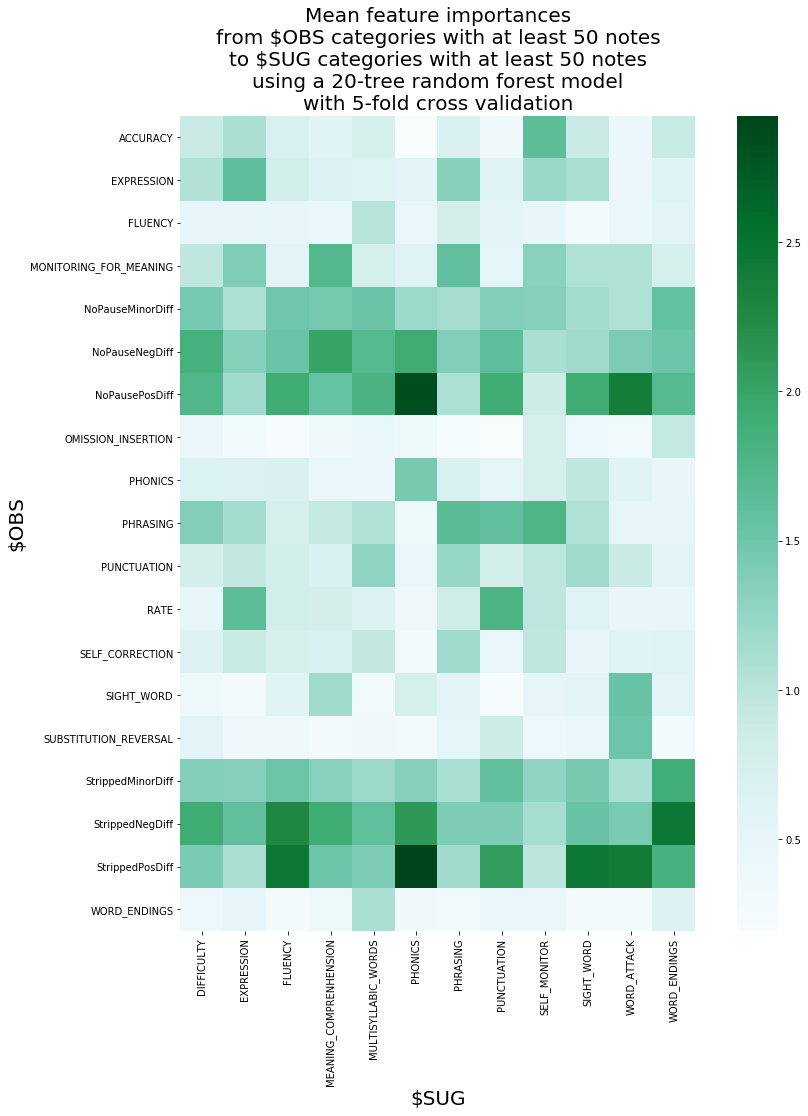

In [10]:
%matplotlib inline

plt.figure(figsize=(15, 15))
title = 'Mean feature importances\nfrom \$OBS categories with at least {} notes\nto \$SUG categories with at \
least {} notes\nusing a {}-tree random forest model\nwith {}-fold cross validation'.format(
        MIN_OBS_THRESHOLD,
        MIN_SUG_THRESHOLD,
        N_TREES,
        N_FOLDS
)
hm = sns.heatmap(
    corr_matrix,
    cmap='BuGn',
    square=True
)
hm.axes.set_title(title, fontsize=20)
hm.set_xlabel('$SUG',fontsize=20)
hm.set_ylabel('$OBS',fontsize=20)
hm.tick_params(labelsize=10)


In [11]:
sug_cats_by_proba = sorted(
    list(sug_cat_to_predictability.keys()),
    key=lambda x: sug_cat_to_predictability[x]
)

sug_cat_predictability_by_proba = [
    sug_cat_to_predictability[c]
    for c in sug_cats_by_proba
]

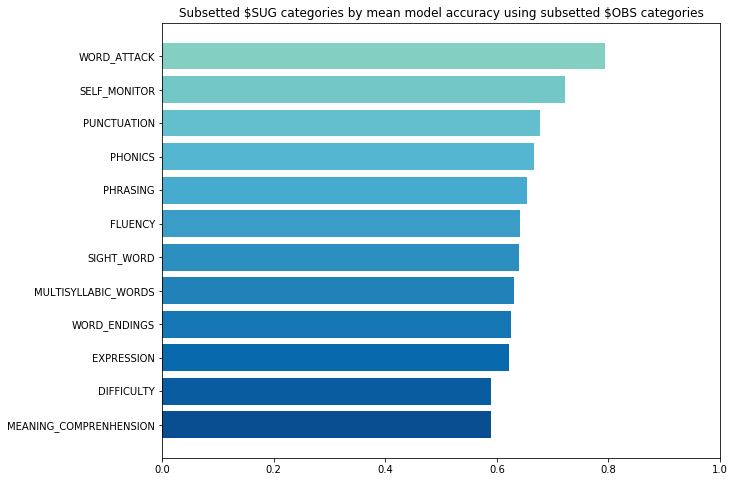

In [12]:
plt.figure(figsize=(10, 8))
plt.title('Subsetted \$SUG categories by mean model accuracy using subsetted \$OBS categories')
f = plt.barh(
    sug_cats_by_proba,
    sug_cat_predictability_by_proba,
    color=sns.color_palette('GnBu_r', len(sug_cats_by_proba) + 10)
)
plt.xlim((0, 1))
plt.show()